In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

from aiutils import copy_logistic_model, load
from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from config import GameConfig
from enums import StartingSplit
from env import DefaultEnvironment
from mcts import GameTree 
from mctsrunner import train_mcts
from mctsutils import *
from player import init_players
from rollout import LogisticRegressionEnsembleRollout

In [43]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

## Full Dominion MCTS ##

In [50]:
tree_name = 'r-r-mcts-mlog-10k-score-base-default'
rollout_name = 'mlog-10k-base-default'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [52]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

In [53]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, sandbox=False, num_players=2, must_include=default_kingdom)
tree = GameTree(train=True)
# players = init_players(['UCT', 'BM'], tree=tree, rollout_type='mlog')
player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)

In [54]:
rollout = LogisticRegressionEnsembleRollout(train=False)

NameError: name 'LogisticRegressionEnsembleRollout' is not defined

In [8]:
model_name = 'base-default-warm-start'
model_path = os.path.join(model_dir, model_name)
model = load(model_path)

In [9]:
dataset_name = 'train-bm-bm-1k-full'
data_path = os.path.join(project_root, 'datasets', dataset_name)
raw_data = load(data_path)
X, y = raw_data[0], raw_data[1]
train_y = y.copy()
train_y[train_y<0] = 0

In [11]:
rollout = player.rollout
rollout.models[8] = copy_logistic_model(model)

In [21]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

In [13]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs['Province']] > 6]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = train_y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

17506

In [14]:
for i, x in enumerate(filtered_X): 
    rollout.buffers[8].store(x, filtered_y[i])

In [15]:
rollout.train = False

In [17]:
train_mcts(env=env, tree=tree, epochs=10000, train_epochs_interval=500, save_epochs=1000, path=tree_path, rollout_path=rollout_path)

 40%|███▉      | 3999/10000 [03:02<04:25, 22.58it/s]ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
 65%|██████▍   | 6497/10000 [05:11<02:36, 22.41it/s]ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
100%|██████████| 10000/10000 [07:56<00:00, 20.98it/s]


In [35]:
node = tree._root
get_depth(node)

15

In [36]:
node = tree._root.children[0].children[0]

In [41]:
tree._root.children[0].children

[None<--n: 90, v: 1645, c: None-->['Copper', 'Estate', 'None'],
 None<--n: 339, v: 6634, c: None-->['Copper', 'Estate', 'None'],
 None<--n: 315, v: 6581, c: None-->['Copper', 'Estate', 'None'],
 None<--n: 61, v: 1308, c: None-->['Copper', 'Estate', 'None']]

In [37]:
L = get_most_visited_paths_at_depth(node, 4, 10)

In [49]:
get_buy_sequence(L[3])

[None, Copper, Duchy, Copper, None]

In [38]:
node.children[2].children

[None<--n: 64, v: 1219, c: Copper-->['Copper', 'Estate', 'Duchy', 'Silver', 'None'],
 None<--n: 5, v: 68, c: Estate-->['Copper', 'Estate', 'Duchy', 'Silver', 'None'],
 None<--n: 2, v: 22, c: None-->['Copper', 'Estate', 'Duchy', 'Silver', 'None']]

In [102]:
model_name = 'r-r-logistic-pred-1k-50'
model_path = os.path.join(model_dir, model_name)
plot_model = load(model_path)

<AxesSubplot:>

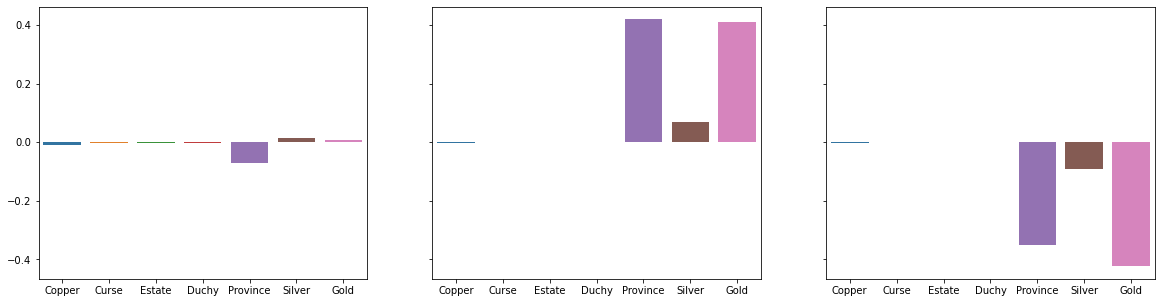

In [42]:
i=8
# plot_model = player.rollout.models[i]
plot_model = model

agent_weights = plot_model.coef_[0][7:14]
opp_weights = plot_model.coef_[0][14:]
supply_weights = plot_model.coef_[0][:7]
# cards = list(env.game.state.feature.idxs.keys())

f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])

In [106]:
agent_weights_comp = plot_model.coef_[0][7:14]
opp_weights_comp = plot_model.coef_[0][14:]
supply_weights_comp = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

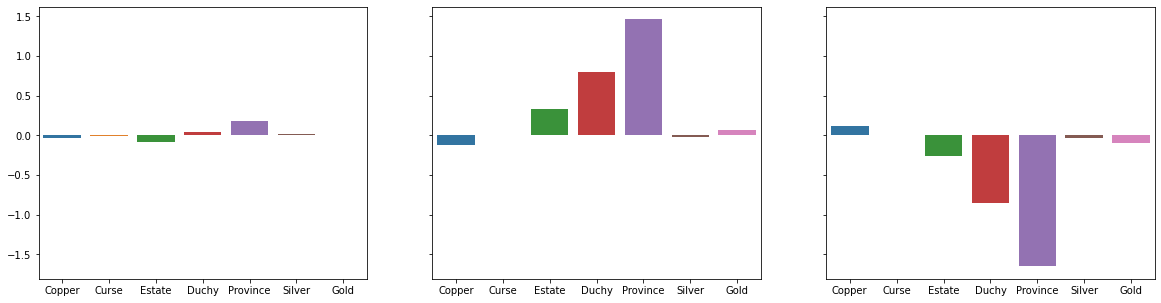

In [107]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights_comp, ax=axes[0])
sns.barplot(x=cards, y=agent_weights_comp, ax=axes[1])
sns.barplot(x=cards, y=opp_weights_comp, ax=axes[2])